In [ ]:
# Подход: делаем эмбеддинги stl-файлов, вокруг них кластеризуем изображения (пока неудачно)

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from stl import mesh  # pip install numpy-stl
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

In [2]:
# Конфигурация
STL_DIR = "stl_dir"  # Папка с STL-файлами
EMBEDDING_SIZE = 512  # Размерность эмбеддингов
NUM_POINTS = 1024     # Количество точек для семплинга из каждого STL
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 1. Загрузка и предобработка STL-файлов
def load_and_sample_stl(filepath, num_points):
    """Загрузка STL-файла и семплинг точек с его поверхности"""
    stl_mesh = mesh.Mesh.from_file(filepath)
    points = stl_mesh.points.reshape(-1, 3)
    
    # Если точек больше чем нужно - семплируем случайные
    if len(points) > num_points:
        idx = np.random.choice(len(points), num_points, replace=False)
        points = points[idx]
    # Если точек меньше - дублируем существующие
    elif len(points) < num_points:
        idx = np.random.choice(len(points), num_points - len(points), replace=True)
        points = np.concatenate([points, points[idx]], axis=0)
    
    return points.astype(np.float32)

In [4]:
# 2. Создание датасета
class STLDataset(Dataset):
    def __init__(self, stl_dir, num_points):
        self.stl_dir = stl_dir
        self.num_points = num_points
        self.filepaths = [os.path.join(stl_dir, f) for f in os.listdir(stl_dir) if f.endswith('.stl')]
        
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        points = load_and_sample_stl(self.filepaths[idx], self.num_points)
        # Нормализация точек
        points = StandardScaler().fit_transform(points)
        return torch.from_numpy(points).float()

In [49]:
# 3. Модель PointNet для извлечения эмбеддингов
class PointNetEmbedding(nn.Module):
    def __init__(self, embedding_size):
        super().__init__()
        # Полносвязные слои вместо сверточных
        self.fc1 = nn.Linear(512, 256)  # Предполагаем, что входной эмбеддинг 512D
        self.fc2 = nn.Linear(256, embedding_size)
        self.bn1 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        # Ожидаем вход [batch_size, embedding_dim]
        if x.dim() == 3:
            x = x.squeeze(1)  # Удаляем лишнюю размерность если есть
        
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        return torch.nn.functional.normalize(x, p=2, dim=1)

In [17]:
# 4. Функция потерь для разнесения эмбеддингов
def spread_loss(embeddings):
    n = len(embeddings)
    embeddings = torch.nn.functional.normalize(embeddings, dim=1)  # На сфере
    dots = torch.mm(embeddings, embeddings.T)
    loss = -torch.mean(dots)  # Минимизируем косинусную близость
    
    # Гарантируем минимум расстояния
    min_dist = torch.min(1 - dots)  # Косинусное расстояние ∈ [0, 2]
    loss += torch.relu(1.0 - min_dist)  # Штраф, если min_dist < 1.0
    return loss

In [7]:
# 5. Обучение модели
def train_model():
    # Создаем датасет и загрузчик
    dataset = STLDataset(STL_DIR, NUM_POINTS)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # Инициализируем модель
    model = PointNetEmbedding(EMBEDDING_SIZE).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Цикл обучения
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0.0
        
        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            batch = batch.to(DEVICE)
            
            # Получаем эмбеддинги
            embeddings = model(batch)
            
            # Вычисляем функцию потерь
            loss = spread_loss(embeddings)
            
            # Оптимизация
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")
    
    return model

In [8]:
# 6. Сохранение эмбеддингов
def save_embeddings(model):
    dataset = STLDataset(STL_DIR, NUM_POINTS)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model.eval()
    all_embeddings = []
    filenames = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(DEVICE)
            embeddings = model(batch)
            all_embeddings.append(embeddings.cpu().numpy())
    
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    filenames = [os.path.basename(f) for f in dataset.filepaths]
    
    # Сохраняем эмбеддинги
    np.savez("stl_embeddings.npz", embeddings=all_embeddings, filenames=filenames)
    print(f"Saved embeddings for {len(filenames)} files with shape {all_embeddings.shape}")


In [18]:
# Главная функция
if __name__ == "__main__":
    # Проверяем наличие файлов
    if not os.path.exists(STL_DIR) or not os.listdir(STL_DIR):
        raise ValueError(f"Directory {STL_DIR} is empty or does not exist")
    
    print(f"Using device: {DEVICE}")
    print(f"Embedding size: {EMBEDDING_SIZE}")
    print(f"Found {len(os.listdir(STL_DIR))} STL files")
    
    # Обучаем модель
    trained_model = train_model()
    
    # Сохраняем эмбеддинги
    save_embeddings(trained_model)

Using device: cpu
Embedding size: 512
Found 10 STL files


Epoch 1/100: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.03it/s]


Epoch 1, Loss: 0.0306


Epoch 2/100: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.36it/s]


Epoch 2, Loss: 0.0199


Epoch 3/100: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.40it/s]


Epoch 3, Loss: 0.0159


Epoch 4/100: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.28it/s]


Epoch 4, Loss: 0.0121


Epoch 5/100: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.62it/s]


Epoch 5, Loss: 0.0095


Epoch 6/100: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


Epoch 6, Loss: 0.0082


Epoch 7/100: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.31it/s]


Epoch 7, Loss: 0.0069


Epoch 8/100: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.63it/s]


Epoch 8, Loss: 0.0061


Epoch 9/100: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.57it/s]


Epoch 9, Loss: 0.0053


Epoch 10/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.91it/s]


Epoch 10, Loss: 0.0047


Epoch 11/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.21it/s]


Epoch 11, Loss: 0.0044


Epoch 12/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.48it/s]


Epoch 12, Loss: 0.0037


Epoch 13/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.26it/s]


Epoch 13, Loss: 0.0033


Epoch 14/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.20it/s]


Epoch 14, Loss: 0.0031


Epoch 15/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.48it/s]


Epoch 15, Loss: 0.0028


Epoch 16/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.67it/s]


Epoch 16, Loss: 0.0028


Epoch 17/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.44it/s]


Epoch 17, Loss: 0.0022


Epoch 18/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.53it/s]


Epoch 18, Loss: 0.0021


Epoch 19/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.55it/s]


Epoch 19, Loss: 0.0021


Epoch 20/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


Epoch 20, Loss: 0.0019


Epoch 21/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.83it/s]


Epoch 21, Loss: 0.0018


Epoch 22/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.82it/s]


Epoch 22, Loss: 0.0018


Epoch 23/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.80it/s]


Epoch 23, Loss: 0.0016


Epoch 24/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.62it/s]


Epoch 24, Loss: 0.0015


Epoch 25/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.89it/s]


Epoch 25, Loss: 0.0015


Epoch 26/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26it/s]


Epoch 26, Loss: 0.0013


Epoch 27/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


Epoch 27, Loss: 0.0013


Epoch 28/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.85it/s]


Epoch 28, Loss: 0.0012


Epoch 29/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.12it/s]


Epoch 29, Loss: 0.0012


Epoch 30/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.15it/s]


Epoch 30, Loss: 0.0012


Epoch 31/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.59it/s]


Epoch 31, Loss: 0.0010


Epoch 32/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.17it/s]


Epoch 32, Loss: 0.0009


Epoch 33/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.89it/s]


Epoch 33, Loss: 0.0010


Epoch 34/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.44it/s]


Epoch 34, Loss: 0.0009


Epoch 35/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.69it/s]


Epoch 35, Loss: 0.0009


Epoch 36/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.38it/s]


Epoch 36, Loss: 0.0010


Epoch 37/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.67it/s]


Epoch 37, Loss: 0.0008


Epoch 38/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.08it/s]


Epoch 38, Loss: 0.0008


Epoch 39/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.26it/s]


Epoch 39, Loss: 0.0008


Epoch 40/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.04it/s]


Epoch 40, Loss: 0.0007


Epoch 41/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.55it/s]


Epoch 41, Loss: 0.0007


Epoch 42/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.95it/s]


Epoch 42, Loss: 0.0008


Epoch 43/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.15it/s]


Epoch 43, Loss: 0.0006


Epoch 44/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.68it/s]


Epoch 44, Loss: 0.0007


Epoch 45/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.71it/s]


Epoch 45, Loss: 0.0005


Epoch 46/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.32it/s]


Epoch 46, Loss: 0.0006


Epoch 47/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]


Epoch 47, Loss: 0.0006


Epoch 48/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.09it/s]


Epoch 48, Loss: 0.0005


Epoch 49/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s]


Epoch 49, Loss: 0.0006


Epoch 50/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.81it/s]


Epoch 50, Loss: 0.0005


Epoch 51/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.61it/s]


Epoch 51, Loss: 0.0005


Epoch 52/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.17it/s]


Epoch 52, Loss: 0.0005


Epoch 53/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.70it/s]


Epoch 53, Loss: 0.0006


Epoch 54/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.06it/s]


Epoch 54, Loss: 0.0005


Epoch 55/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.95it/s]


Epoch 55, Loss: 0.0005


Epoch 56/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.36it/s]


Epoch 56, Loss: 0.0004


Epoch 57/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.24it/s]


Epoch 57, Loss: 0.0005


Epoch 58/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.79it/s]


Epoch 58, Loss: 0.0005


Epoch 59/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Epoch 59, Loss: 0.0004


Epoch 60/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.70it/s]


Epoch 60, Loss: 0.0004


Epoch 61/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.61it/s]


Epoch 61, Loss: 0.0004


Epoch 62/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.10it/s]


Epoch 62, Loss: 0.0004


Epoch 63/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.81it/s]


Epoch 63, Loss: 0.0004


Epoch 64/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.10it/s]


Epoch 64, Loss: 0.0004


Epoch 65/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.74it/s]


Epoch 65, Loss: 0.0004


Epoch 66/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.35it/s]


Epoch 66, Loss: 0.0004


Epoch 67/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.00it/s]


Epoch 67, Loss: 0.0004


Epoch 68/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.04it/s]


Epoch 68, Loss: 0.0004


Epoch 69/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.27it/s]


Epoch 69, Loss: 0.0003


Epoch 70/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.10it/s]


Epoch 70, Loss: 0.0003


Epoch 71/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.74it/s]


Epoch 71, Loss: 0.0004


Epoch 72/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.88it/s]


Epoch 72, Loss: 0.0004


Epoch 73/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.26it/s]


Epoch 73, Loss: 0.0003


Epoch 74/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.27it/s]


Epoch 74, Loss: 0.0003


Epoch 75/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.77it/s]


Epoch 75, Loss: 0.0003


Epoch 76/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.61it/s]


Epoch 76, Loss: 0.0003


Epoch 77/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.41it/s]


Epoch 77, Loss: 0.0003


Epoch 78/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.65it/s]


Epoch 78, Loss: 0.0003


Epoch 79/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.39it/s]


Epoch 79, Loss: 0.0003


Epoch 80/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.40it/s]


Epoch 80, Loss: 0.0003


Epoch 81/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.75it/s]


Epoch 81, Loss: 0.0003


Epoch 82/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.49it/s]


Epoch 82, Loss: 0.0003


Epoch 83/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.65it/s]


Epoch 83, Loss: 0.0002


Epoch 84/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.21it/s]


Epoch 84, Loss: 0.0003


Epoch 85/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.94it/s]


Epoch 85, Loss: 0.0003


Epoch 86/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.61it/s]


Epoch 86, Loss: 0.0002


Epoch 87/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


Epoch 87, Loss: 0.0003


Epoch 88/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.99it/s]


Epoch 88, Loss: 0.0003


Epoch 89/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.73it/s]


Epoch 89, Loss: 0.0002


Epoch 90/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.34it/s]


Epoch 90, Loss: 0.0003


Epoch 91/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.99it/s]


Epoch 91, Loss: 0.0002


Epoch 92/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 92, Loss: 0.0002


Epoch 93/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.99it/s]


Epoch 93, Loss: 0.0003


Epoch 94/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.80it/s]


Epoch 94, Loss: 0.0003


Epoch 95/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]


Epoch 95, Loss: 0.0002


Epoch 96/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.08it/s]


Epoch 96, Loss: 0.0002


Epoch 97/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.98it/s]


Epoch 97, Loss: 0.0002


Epoch 98/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.92it/s]


Epoch 98, Loss: 0.0002


Epoch 99/100: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.23it/s]


Epoch 99, Loss: 0.0002


Epoch 100/100: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.81it/s]


Epoch 100, Loss: 0.0002
Saved embeddings for 10 files with shape (10, 512)


In [11]:
# Создаём папку для сохранения эмбеддингов
os.makedirs('stl_vector', exist_ok=True)

In [19]:
# 7. Улучшенная функция сохранения эмбеддингов (в отдельную папку)
def save_embeddings_to_folder(model):
    dataset = STLDataset(STL_DIR, NUM_POINTS)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model.eval()
    all_embeddings = []
    filenames = []
    
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(DEVICE)
            embeddings = model(batch)
            all_embeddings.append(embeddings.cpu().numpy())
    
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    filenames = [os.path.basename(f) for f in dataset.filepaths]
    
    # Сохраняем каждый эмбеддинг отдельным файлом
    for emb, name in zip(all_embeddings, filenames):
        np.save(os.path.join('stl_vector', name.replace('.stl', '.npy')), emb)
    
    # Сохраняем метаданные
    np.savez(os.path.join('stl_vector', 'metadata.npz'), 
             filenames=filenames, 
             mean_embedding=np.mean(all_embeddings, axis=0),
             std_embedding=np.std(all_embeddings, axis=0))
    
    print(f"Saved {len(filenames)} embeddings to 'stl_vector' folder")
    return all_embeddings, filenames

In [20]:
# 8. Функция загрузки эмбеддингов
def load_embeddings_from_folder():
    metadata_path = os.path.join('stl_vector', 'metadata.npz')
    if not os.path.exists(metadata_path):
        raise FileNotFoundError("No embeddings found. Train model first.")
    
    data = np.load(metadata_path)
    filenames = data['filenames']
    all_embeddings = []
    
    for name in filenames:
        emb_path = os.path.join('stl_vector', name.replace('.stl', '.npy'))
        all_embeddings.append(np.load(emb_path))
    
    return np.array(all_embeddings), filenames

In [21]:
# 9. Функции визуализации
def visualize_embeddings(embeddings, filenames):
    # Уменьшаем размерность для визуализации
    pca = PCA(n_components=2)
    tsne = TSNE(n_components=2, perplexity=min(30, len(embeddings)-1))
    
    emb_pca = pca.fit_transform(embeddings)
    emb_tsne = tsne.fit_transform(embeddings)
    
    # Создаём фигуру
    plt.figure(figsize=(20, 8))
    
    # PCA визуализация
    plt.subplot(1, 2, 1)
    plt.scatter(emb_pca[:, 0], emb_pca[:, 1], alpha=0.5)
    for i, name in enumerate(filenames):
        plt.annotate(name.split('.')[0], (emb_pca[i, 0], emb_pca[i, 1]), fontsize=8)
    plt.title('PCA Visualization')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    # t-SNE визуализация
    plt.subplot(1, 2, 2)
    plt.scatter(emb_tsne[:, 0], emb_tsne[:, 1], alpha=0.5)
    for i, name in enumerate(filenames):
        plt.annotate(name.split('.')[0], (emb_tsne[i, 0], emb_tsne[i, 1]), fontsize=8)
    plt.title('t-SNE Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    plt.tight_layout()
    plt.savefig('embeddings_visualization.png', dpi=300)
    plt.show()

In [22]:
embeddings, filenames = save_embeddings_to_folder(trained_model)

Saved 10 embeddings to 'stl_vector' folder


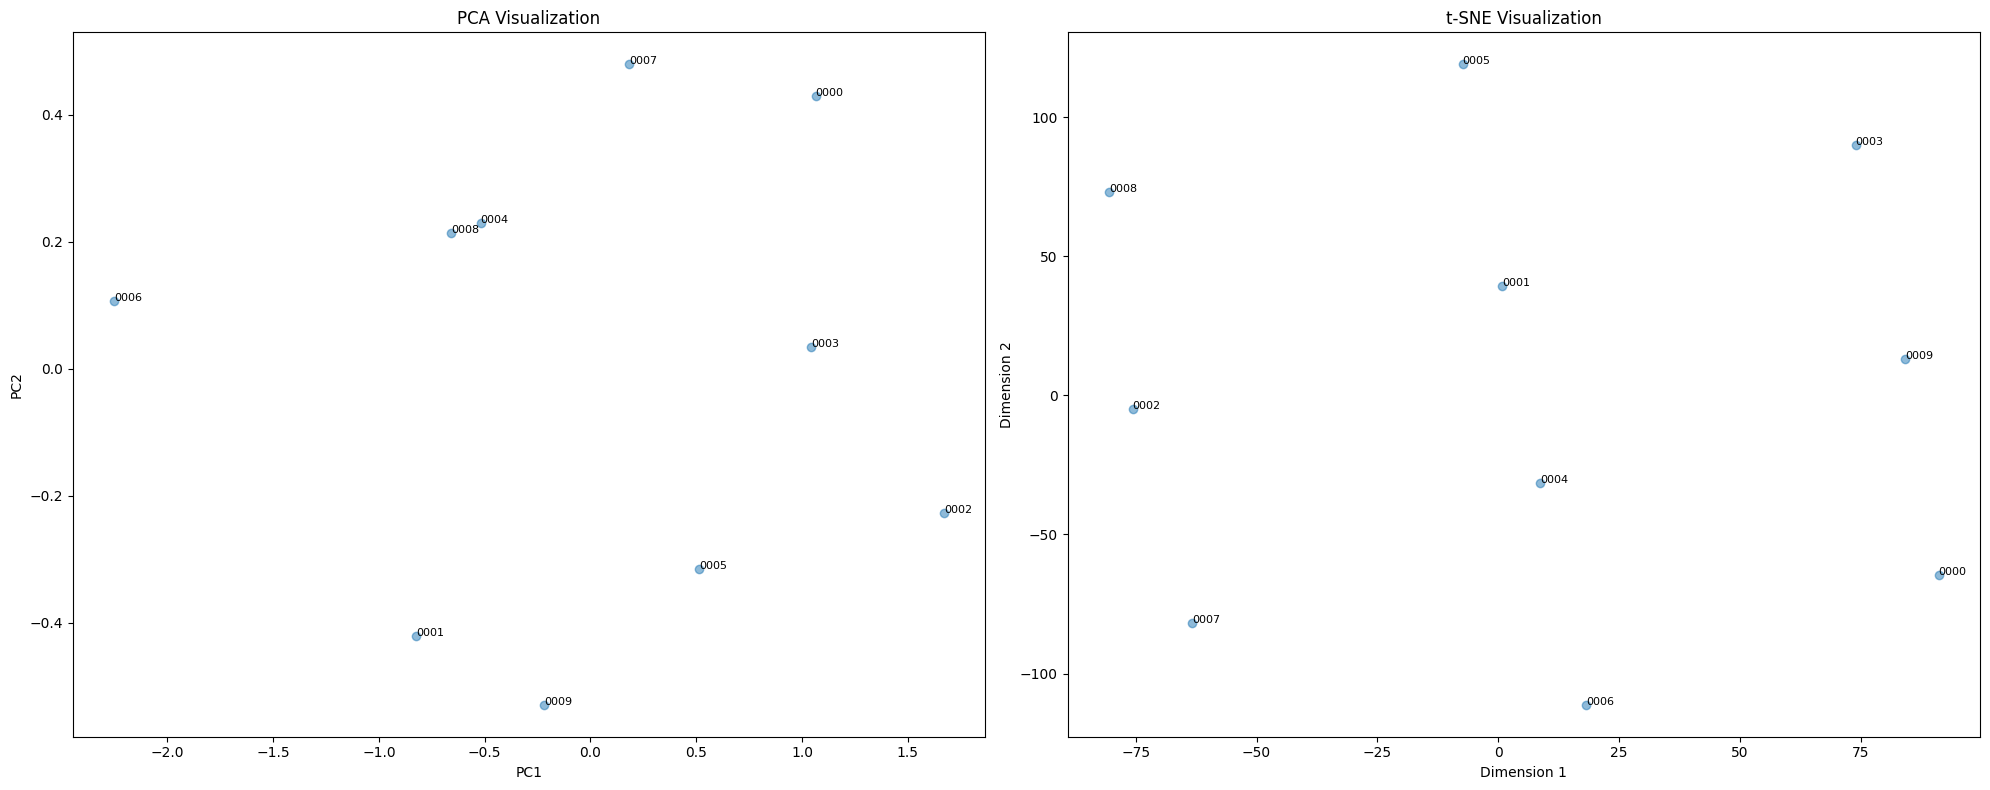

In [23]:
try:
    visualize_embeddings(embeddings, filenames)
except Exception as e:
    print(f"Thumbnail visualization failed: {e}")
    print("You need to implement STL thumbnail generation first")

In [43]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

# Конфигурация
STL_EMBEDDING_SIZE = 512  # Как в вашем коде
IMAGE_EMBEDDING_SIZE = 512  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
LR = 0.0001
EPOCHS = 50

In [37]:
# 1. Загрузка STL-эмбеддингов
def load_stl_embeddings(embeddings_dir='stl_vector'):
    stl_emb_dict = {}
    npy_files = [f for f in os.listdir(embeddings_dir) if f.endswith('.npy')]
    
    for npy_file in npy_files:
        model_id = npy_file.replace('.stl.npy', '').replace('.npy', '')
        emb_path = os.path.join(embeddings_dir, npy_file)
        stl_emb_dict[model_id] = np.load(emb_path)
    
    print(f"Загружено {len(stl_emb_dict)} STL-эмбеддингов")
    return stl_emb_dict

# 2. Сопоставление model_id и папок с изображениями
def find_image_folders(base_dir='images_train'):
    """Находит соответствие между model_id и папками"""
    folder_map = {}
    for folder in os.listdir(base_dir):
        if folder.startswith('model_'):
            # Извлекаем номер модели (model_1 -> 1)
            folder_num = folder.split('_')[1]
            # Предполагаем, что файлы внутри называются 000X_Y.png
            first_image = os.listdir(os.path.join(base_dir, folder))[0]
            model_id = first_image.split('_')[0]
            folder_map[model_id] = os.path.join(base_dir, folder)
    
    print(f"Найдено {len(folder_map)} папок с изображениями")
    return folder_map


In [92]:
class MultiModalDataset(Dataset):
    def __init__(self, stl_emb_dict, image_folders):
        self.stl_emb_dict = stl_emb_dict
        self.image_paths = []
        self.model_ids = []
        
        # Собираем все изображения и соответствующие model_ids
        for model_id, emb in stl_emb_dict.items():
            # Формируем путь к папке с изображениями
            folder_num = int(model_id) + 1  # предполагаем, что model_id = "0000", "0001" и т.д.
            folder_path = os.path.join("images_train", f"model_{folder_num}")
            
            if os.path.exists(folder_path):
                for img_name in sorted(os.listdir(folder_path)):
                    if img_name.endswith('.png') and img_name.startswith(model_id):
                        self.image_paths.append(os.path.join(folder_path, img_name))
                        self.model_ids.append(model_id)
        
        # Проверка, что данные найдены
        if len(self.image_paths) == 0:
            raise ValueError("Не найдено ни одного изображения!")
        
        # Трансформации для изображений
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Загрузка изображения
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        
        # Получаем соответствующий STL эмбеддинг
        model_id = self.model_ids[idx]
        stl_emb = torch.FloatTensor(self.stl_emb_dict[model_id])
        
        return img, stl_emb, model_id  # Теперь точно возвращаем 3 элемента

In [26]:
class ImageEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(512, IMAGE_EMBEDDING_SIZE)
        
    def forward(self, x):
        return torch.nn.functional.normalize(self.resnet(x), p=2, dim=1)

In [27]:
class CrossModalTripletLoss(nn.Module):
    def __init__(self, margin=5.0):
        super().__init__()
        self.margin = margin
        
    def forward(self, img_emb, stl_pos_emb, stl_neg_emb):
        # Расстояния: изображение -> STL
        pos_dist = torch.cdist(img_emb.unsqueeze(0), stl_pos_emb.unsqueeze(0))
        neg_dist = torch.cdist(img_emb.unsqueeze(0), stl_neg_emb.unsqueeze(0))
        
        # Triplet Loss
        loss = torch.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

In [130]:
class SharedEmbeddingSpace(nn.Module):
    def __init__(self, stl_embedding_size=512, image_embedding_size=512, shared_size=256):
        super().__init__()
        
        # STL branch
        self.stl_projection = nn.Sequential(
            nn.Linear(stl_embedding_size, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Linear(384, shared_size)
        )
        
        # Image branch
        self.image_projection = nn.Sequential(
            nn.Linear(image_embedding_size, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Linear(384, shared_size)
        )
        
    def forward(self, stl_emb, image_emb):
        stl_proj = F.normalize(self.stl_projection(stl_emb), p=2, dim=1)
        img_proj = F.normalize(self.image_projection(image_emb), p=2, dim=1)
        return stl_proj, img_proj

In [143]:
class ImprovedTripletLoss(nn.Module):
    def __init__(self, margin=0.2, alpha=0.02):
        super().__init__()
        self.margin = margin
        self.alpha = alpha  # L2 regularization weight
        
    def forward(self, x1, x2, label):
        dist = F.pairwise_distance(x1, x2)
        loss = (label * dist.pow(2) + 
               (1-label) * F.relu(self.margin - dist).pow(2))
        return loss.mean()

In [87]:
def custom_collate_fn(batch):
    """Явно объявленная функция для объединения данных в батчи"""
    imgs = torch.stack([x[0] for x in batch])
    stls = torch.stack([x[1] for x in batch])
    ids = [x[2] for x in batch]
    return imgs, stls, ids

In [132]:
def train_improved(stl_emb_dict, image_folders):
    dataset = MultiModalDataset(stl_emb_dict, image_folders)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    
    # Models
    stl_model = PointNetEmbedding(STL_EMBEDDING_SIZE).to(DEVICE)
    image_model = ImageEmbedder().to(DEVICE)
    shared_space = SharedEmbeddingSpace().to(DEVICE)
    
    # Loss and optimizer
    criterion = ImprovedTripletLoss(margin=0.5)
    optimizer = optim.Adam([
        {'params': stl_model.parameters()},
        {'params': image_model.parameters()},
        {'params': shared_space.parameters()}
    ], lr=0.0001)
    
    for epoch in range(100):
        stl_model.train()
        image_model.train()
        shared_space.train()
        
        total_loss = 0
        for imgs, stls, labels in tqdm(dataloader):
            imgs = imgs.to(DEVICE)
            stls = stls.to(DEVICE)
            
            # Get embeddings
            stl_emb = stl_model(stls)
            img_emb = image_model(imgs)
            
            # Project to shared space
            stl_proj, img_proj = shared_space(stl_emb, img_emb)
            
            # Compute loss
            loss = criterion(stl_proj, img_proj, labels)
            
            # Optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")
    
    return stl_model, image_model, shared_space

In [35]:
# Проверка содержимого папки
print("Содержимое папки stl_vector:")
print(os.listdir('stl_vector'))

Содержимое папки stl_vector:
['0000.npy', '0001.npy', '0002.npy', '0003.npy', '0004.npy', '0005.npy', '0006.npy', '0007.npy', '0008.npy', '0009.npy', 'metadata.npz']


In [144]:
# Загрузка эмбеддингов
stl_emb_dict = load_stl_embeddings()

# Папки с изображениями (предполагаем, что model_id совпадают с именами подпапок)
image_folders = find_image_folders()
if not image_folders:
    raise ValueError("Не найдено ни одной папки с изображениями!")
dataset = MultiModalDataset(stl_emb_dict, image_folders)
# Обучение (как в вашем коде)
image_model, stl_model = train_cross_modal(stl_emb_dict, image_folders)

D:\ANACONDA\envs\aiijc_2025\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\ANACONDA\envs\aiijc_2025\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Загружено 10 STL-эмбеддингов
Найдено 10 папок с изображениями
Загружено 260 изображений


Epoch 1/50: 100%|███████████████████████████████████████████████████████████| 9/9 [00:40<00:00,  4.52s/it, loss=0.0000]


Epoch 1, Avg Loss: 0.0000


Epoch 2/50: 100%|███████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.84s/it, loss=0.0000]


Epoch 2, Avg Loss: 0.0000


Epoch 3/50: 100%|███████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.68s/it, loss=0.0000]


Epoch 3, Avg Loss: 0.0000


Epoch 4/50: 100%|███████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.86s/it, loss=0.0000]


Epoch 4, Avg Loss: 0.0000


Epoch 5/50: 100%|███████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.72s/it, loss=0.0000]


Epoch 5, Avg Loss: 0.0000


Epoch 6/50: 100%|███████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  4.67s/it, loss=0.0000]


Epoch 6, Avg Loss: 0.0000


Epoch 7/50: 100%|███████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  4.60s/it, loss=0.0000]


Epoch 7, Avg Loss: 0.0000


Epoch 8/50: 100%|███████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.71s/it, loss=0.0000]


Epoch 8, Avg Loss: 0.0000


Epoch 9/50: 100%|███████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.76s/it, loss=0.0000]


Epoch 9, Avg Loss: 0.0000


Epoch 10/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.78s/it, loss=0.0000]


Epoch 10, Avg Loss: 0.0000


Epoch 11/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.88s/it, loss=0.0000]


Epoch 11, Avg Loss: 0.0000


Epoch 12/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.71s/it, loss=0.0000]


Epoch 12, Avg Loss: 0.0000


Epoch 13/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.68s/it, loss=0.0000]


Epoch 13, Avg Loss: 0.0000


Epoch 14/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.68s/it, loss=0.0000]


Epoch 14, Avg Loss: 0.0000


Epoch 15/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.68s/it, loss=0.0000]


Epoch 15, Avg Loss: 0.0000


Epoch 16/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.76s/it, loss=0.0000]


Epoch 16, Avg Loss: 0.0000


Epoch 17/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.81s/it, loss=0.0000]


Epoch 17, Avg Loss: 0.0000


Epoch 18/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.78s/it, loss=0.0000]


Epoch 18, Avg Loss: 0.0000


Epoch 19/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.69s/it, loss=0.0000]


Epoch 19, Avg Loss: 0.0000


Epoch 20/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.71s/it, loss=0.0000]


Epoch 20, Avg Loss: 0.0000


Epoch 21/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.69s/it, loss=0.0000]


Epoch 21, Avg Loss: 0.0000


Epoch 22/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.77s/it, loss=0.0000]


Epoch 22, Avg Loss: 0.0000


Epoch 23/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.72s/it, loss=0.0000]


Epoch 23, Avg Loss: 0.0000


Epoch 24/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  4.67s/it, loss=0.0000]


Epoch 24, Avg Loss: 0.0000


Epoch 25/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  4.65s/it, loss=0.0000]


Epoch 25, Avg Loss: 0.0000


Epoch 26/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  4.65s/it, loss=0.0000]


Epoch 26, Avg Loss: 0.0000


Epoch 27/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.75s/it, loss=0.0000]


Epoch 27, Avg Loss: 0.0000


Epoch 28/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.73s/it, loss=0.0000]


Epoch 28, Avg Loss: 0.0000


Epoch 29/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  4.65s/it, loss=0.0000]


Epoch 29, Avg Loss: 0.0000


Epoch 30/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.69s/it, loss=0.0000]


Epoch 30, Avg Loss: 0.0000


Epoch 31/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.70s/it, loss=0.0000]


Epoch 31, Avg Loss: 0.0000


Epoch 32/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  4.62s/it, loss=0.0000]


Epoch 32, Avg Loss: 0.0000


Epoch 33/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.71s/it, loss=0.0000]


Epoch 33, Avg Loss: 0.0000


Epoch 34/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.79s/it, loss=0.0000]


Epoch 34, Avg Loss: 0.0000


Epoch 35/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.72s/it, loss=0.0000]


Epoch 35, Avg Loss: 0.0000


Epoch 36/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.82s/it, loss=0.0000]


Epoch 36, Avg Loss: 0.0000


Epoch 37/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.68s/it, loss=0.0000]


Epoch 37, Avg Loss: 0.0000


Epoch 38/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.87s/it, loss=0.0000]


Epoch 38, Avg Loss: 0.0000


Epoch 39/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.69s/it, loss=0.0000]


Epoch 39, Avg Loss: 0.0000


Epoch 40/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.72s/it, loss=0.0000]


Epoch 40, Avg Loss: 0.0000


Epoch 41/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  4.65s/it, loss=0.0000]


Epoch 41, Avg Loss: 0.0000


Epoch 42/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.73s/it, loss=0.0000]


Epoch 42, Avg Loss: 0.0000


Epoch 43/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.75s/it, loss=0.0000]


Epoch 43, Avg Loss: 0.0000


Epoch 44/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.69s/it, loss=0.0000]


Epoch 44, Avg Loss: 0.0000


Epoch 45/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.79s/it, loss=0.0000]


Epoch 45, Avg Loss: 0.0000


Epoch 46/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.71s/it, loss=0.0000]


Epoch 46, Avg Loss: 0.0000


Epoch 47/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.74s/it, loss=0.0000]


Epoch 47, Avg Loss: 0.0000


Epoch 48/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.77s/it, loss=0.0000]


Epoch 48, Avg Loss: 0.0000


Epoch 49/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:40<00:00,  4.49s/it, loss=0.0000]


Epoch 49, Avg Loss: 0.0000


Epoch 50/50: 100%|██████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.72s/it, loss=0.0000]

Epoch 50, Avg Loss: 0.0000


In [145]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [146]:
def visualize_embeddings(image_model, stl_model, dataloader):
    # Собираем эмбеддинги отдельно для изображений и STL
    image_embs = []
    stl_embs = []
    model_ids = []
    
    with torch.no_grad():
        # Обрабатываем все данные из DataLoader
        for img_batch, stl_batch, ids_batch in dataloader:
            # Получаем эмбеддинги изображений
            img_emb = image_model(img_batch.to(DEVICE)).cpu()
            image_embs.append(img_emb)
            
            # Получаем эмбеддинги STL
            stl_emb = stl_model(stl_batch.to(DEVICE)).cpu()
            stl_embs.append(stl_emb)
            
            # Сохраняем ID моделей
            model_ids.extend(ids_batch)
    
    # Объединяем все эмбеддинги
    image_embs = torch.cat(image_embs).numpy()
    stl_embs = torch.cat(stl_embs).numpy()
    
    # Для STL берем только уникальные эмбеддинги (по одному на модель)
    unique_stl_embs = []
    unique_model_ids = []
    seen_ids = set()
    
    for emb, model_id in zip(stl_embs, model_ids):
        if model_id not in seen_ids:
            seen_ids.add(model_id)
            unique_stl_embs.append(emb)
            unique_model_ids.append(model_id)
    
    unique_stl_embs = np.array(unique_stl_embs)
    
    # Объединяем все эмбеддинги для визуализации
    all_embs = np.concatenate([image_embs, unique_stl_embs])
    types = ['Image'] * len(image_embs) + ['STL'] * len(unique_stl_embs)
    
    # Создаем фигуру
    plt.figure(figsize=(20, 15))
    
    # PCA 2D
    pca = PCA(n_components=2)
    embs_pca = pca.fit_transform(all_embs)
    plt.subplot(2, 2, 1)
    for t in ['Image', 'STL']:
        mask = np.array(types) == t
        plt.scatter(embs_pca[mask, 0], embs_pca[mask, 1], label=t, alpha=0.6)
    plt.title('PCA 2D')
    plt.legend()
    
    # t-SNE 2D
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embs_tsne = tsne.fit_transform(all_embs)
    plt.subplot(2, 2, 2)
    for t in ['Image', 'STL']:
        mask = np.array(types) == t
        plt.scatter(embs_tsne[mask, 0], embs_tsne[mask, 1], label=t, alpha=0.6)
    plt.title('t-SNE 2D')
    plt.legend()
    
    # PCA 3D
    ax = plt.subplot(2, 2, 3, projection='3d')
    pca_3d = PCA(n_components=3)
    embs_pca_3d = pca_3d.fit_transform(all_embs)
    for t in ['Image', 'STL']:
        mask = np.array(types) == t
        ax.scatter(embs_pca_3d[mask, 0], embs_pca_3d[mask, 1], embs_pca_3d[mask, 2], label=t, alpha=0.6)
    ax.set_title('PCA 3D')
    ax.legend()
    
    # t-SNE 3D
    ax = plt.subplot(2, 2, 4, projection='3d')
    tsne_3d = TSNE(n_components=3, perplexity=30, random_state=42)
    embs_tsne_3d = tsne_3d.fit_transform(all_embs)
    for t in ['Image', 'STL']:
        mask = np.array(types) == t
        ax.scatter(embs_tsne_3d[mask, 0], embs_tsne_3d[mask, 1], embs_tsne_3d[mask, 2], label=t, alpha=0.6)
    ax.set_title('t-SNE 3D')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Использование после обучения:
dataset = MultiModalDataset(stl_emb_dict, image_folders)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)
visualize_embeddings(image_model, stl_model, test_loader)

In [137]:
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


def plot_image_neighbors(image_model, dataloader, image_folders, n_neighbors=5, n_examples=3):
    """
    Визуализирует ближайшие соседи для случайных изображений
    
    Параметры:
        image_model: обученная модель для изображений
        dataloader: DataLoader с изображениями и STL эмбеддингами
        image_folders: список путей к папкам с изображениями
        n_neighbors: количество ближайших соседей
        n_examples: количество примеров для визуализации
    """
    # Собираем все эмбеддинги и пути к изображениям
    all_embeddings = []
    all_image_paths = []
    all_model_ids = []
    
    with torch.no_grad():
        for img_batch, stl_batch, model_ids in dataloader:
            # Получаем эмбеддинги для батча изображений
            emb = image_model(img_batch.to(DEVICE)).cpu().numpy()
            all_embeddings.append(emb)
            
            # Сохраняем пути к изображениям и model_ids
            for i, model_id in enumerate(model_ids):
                # Формируем путь к изображению
                folder_num = int(model_id) + 1  # предполагаем model_id вида "0000", "0001" и т.д.
                folder_path = os.path.join("images_train", f"model_{folder_num}")
                img_path = os.path.join(folder_path, f"{model_id}_{i % 26}.png")  # 26 изображений на модель
                all_image_paths.append(img_path)
                all_model_ids.append(model_id)
    
    all_embeddings = np.concatenate(all_embeddings)
    
    # Проверка, что данные собраны
    if len(all_embeddings) == 0:
        raise ValueError("Не удалось загрузить эмбеддинги изображений")
    if len(all_image_paths) != len(all_embeddings):
        raise ValueError("Количество эмбеддингов и путей не совпадает")

    # Создаем модель ближайших соседей
    neigh = NearestNeighbors(n_neighbors=n_neighbors+1)  # +1 чтобы исключить сам query
    neigh.fit(all_embeddings)
    
    # Выбираем случайные примеры для визуализации
    sample_indices = np.random.choice(len(all_embeddings), 
                                     size=min(n_examples, len(all_embeddings)), 
                                     replace=False)
    
    for idx in sample_indices:
        distances, neighbor_indices = neigh.kneighbors([all_embeddings[idx]])
        
        # Исключаем сам query из соседей
        neighbor_indices = neighbor_indices[0][1:]  # первый элемент - сам query
        distances = distances[0][1:]
        
        plt.figure(figsize=(15, 3))
        plt.suptitle(f"Query image: {os.path.basename(all_image_paths[idx])}\nModel ID: {all_model_ids[idx]}")
        
        # Отображаем query изображение
        plt.subplot(1, n_neighbors+1, 1)
        try:
            img = Image.open(all_image_paths[idx])
            plt.imshow(img)
            plt.title("Query")
            plt.axis('off')
        except FileNotFoundError:
            plt.text(0.5, 0.5, "Image not found", ha='center')
            plt.axis('off')
        
        # Отображаем соседей
        for i, neighbor_idx in enumerate(neighbor_indices):
            plt.subplot(1, n_neighbors+1, i+2)
            try:
                img = Image.open(all_image_paths[neighbor_idx])
                plt.imshow(img)
                plt.title(f"Dist: {distances[i]:.2f}\nID: {all_model_ids[neighbor_idx]}")
                plt.axis('off')
            except FileNotFoundError:
                plt.text(0.5, 0.5, "Image not found", ha='center')
                plt.axis('off')
        
        plt.tight_layout()
        plt.show()

In [138]:
print(image_folders)

{'0000': 'images_train\\model_1', '0009': 'images_train\\model_10', '0001': 'images_train\\model_2', '0002': 'images_train\\model_3', '0003': 'images_train\\model_4', '0004': 'images_train\\model_5', '0005': 'images_train\\model_6', '0006': 'images_train\\model_7', '0007': 'images_train\\model_8', '0008': 'images_train\\model_9'}


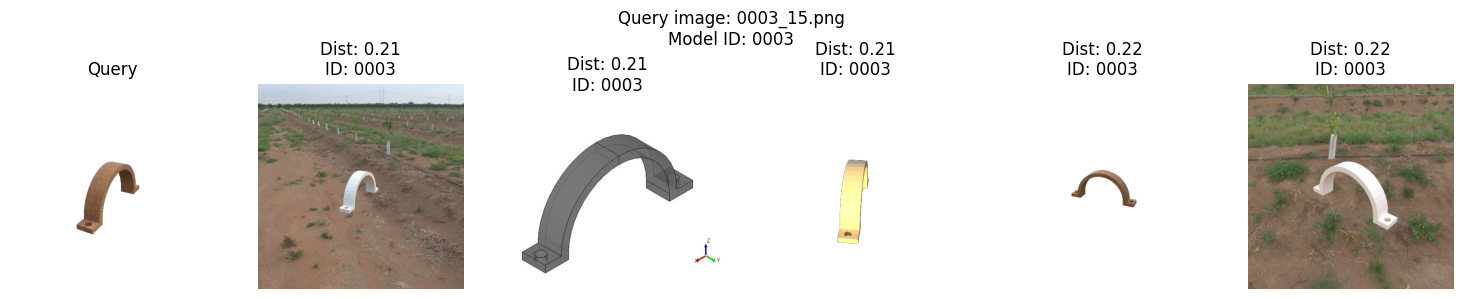

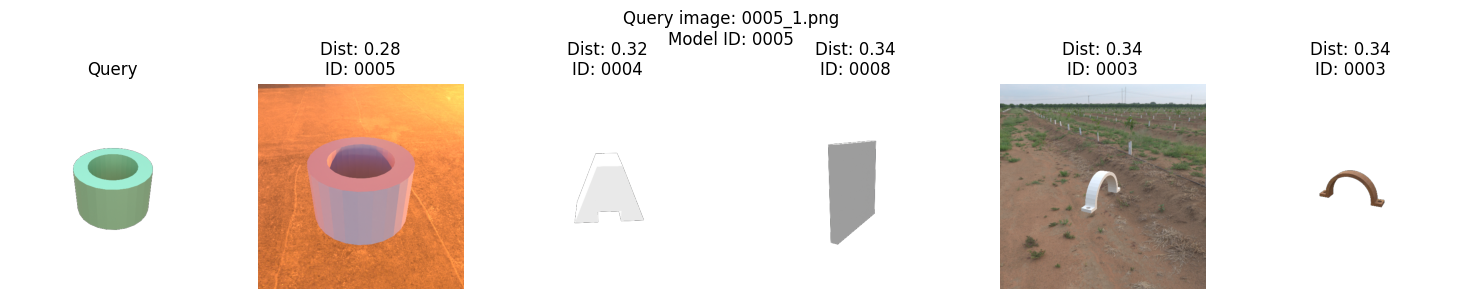

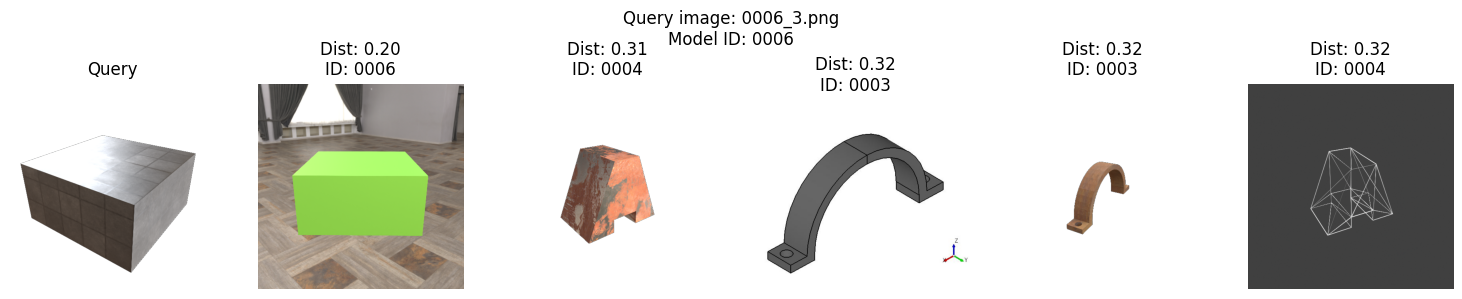

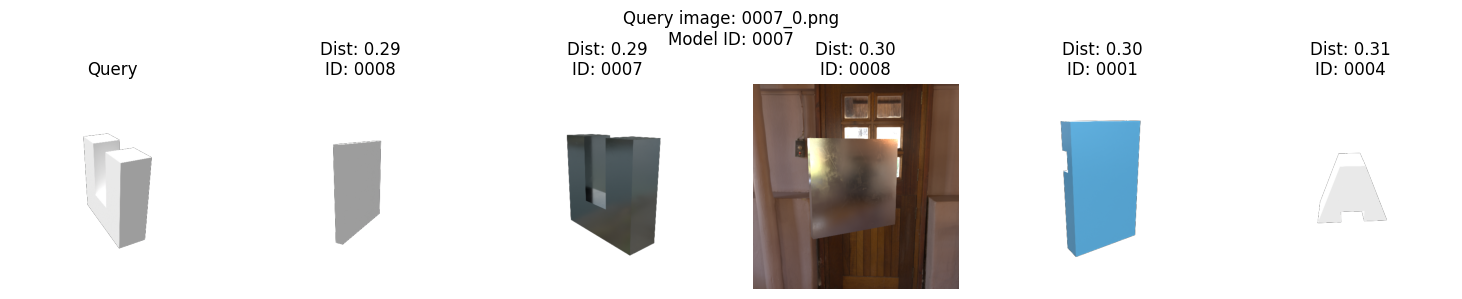

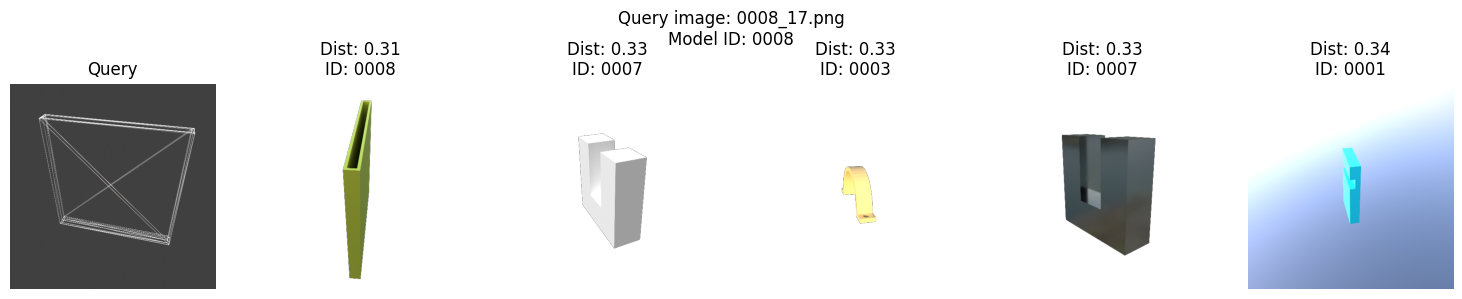

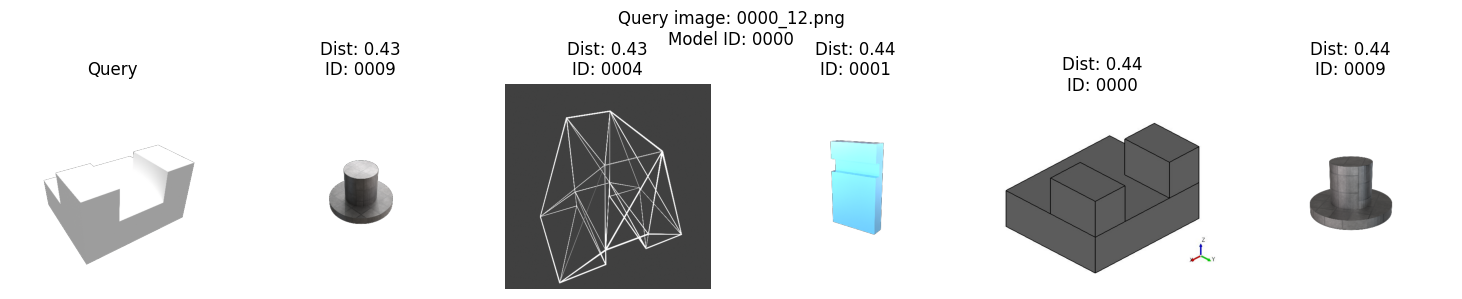

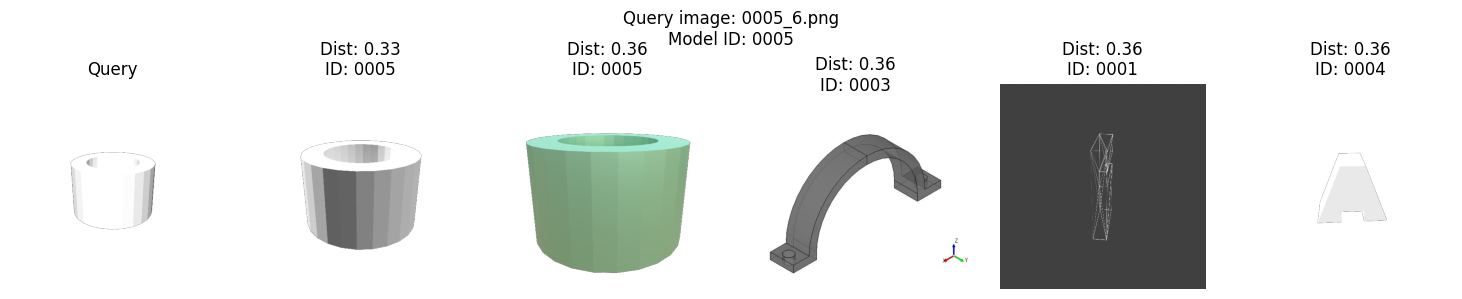

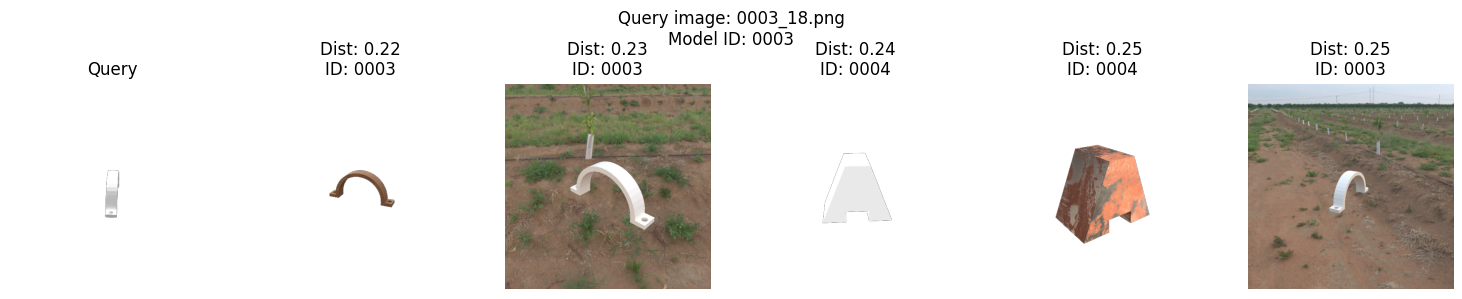

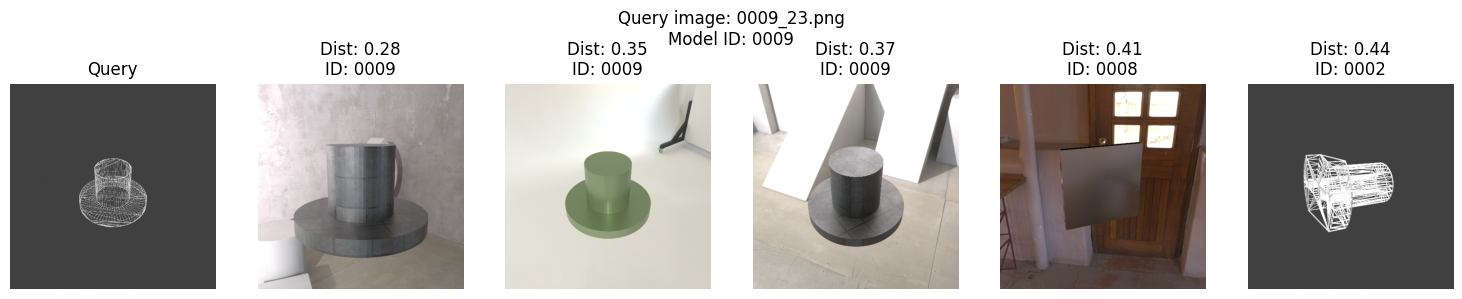

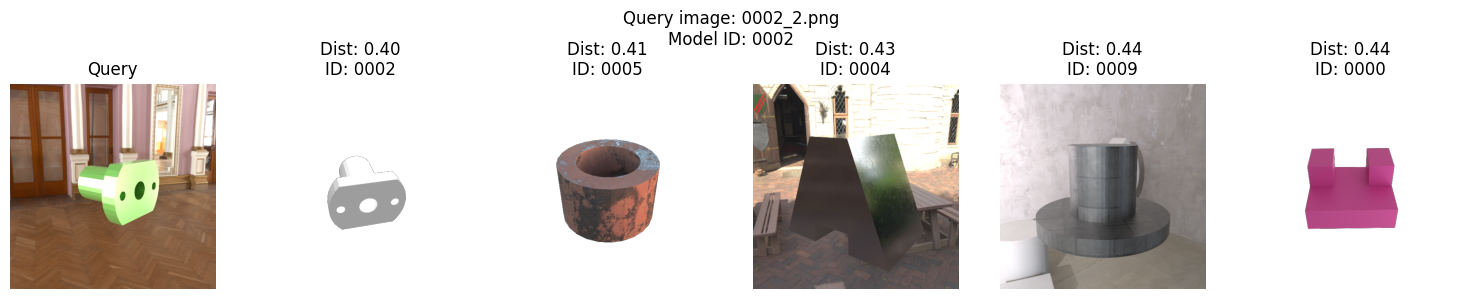

In [140]:
# После обучения моделей
image_folders_2 = []
for i in range(1, 11):
    image_folders_2.append(f"images_train/model_{i}")
plot_image_neighbors(
    image_model=image_model,
    dataloader=test_loader,  # Ваш DataLoader
    image_folders=image_folders_2,  # Список папок
    n_neighbors=5,
    n_examples=10
)

In [141]:
def plot_image_to_stl_neighbors(image_model, stl_model, dataloader, stl_emb_dict, image_folders, n_examples=3):
    """
    Находит ближайшие STL-модели для случайных изображений
    
    Параметры:
        image_model: модель для изображений
        stl_model: модель для STL
        dataloader: DataLoader с изображениями, STL и model_ids
        stl_emb_dict: словарь {model_id: stl_embedding}
        image_folders: список путей к папкам с изображениями
        n_examples: количество примеров для визуализации
    """
    # 1. Подготовка STL-эмбеддингов
    stl_ids = list(stl_emb_dict.keys())
    stl_embeddings = torch.stack([torch.FloatTensor(stl_emb_dict[model_id]) for model_id in stl_ids]).to(DEVICE)
    with torch.no_grad():
        stl_embeddings = stl_model(stl_embeddings).cpu().numpy()
    
    # 2. Сбор эмбеддингов изображений и информации о них
    image_embeddings = []
    image_paths = []
    image_model_ids = []
    
    with torch.no_grad():
        for img_batch, _, model_ids in dataloader:
            # Получаем эмбеддинги изображений
            emb = image_model(img_batch.to(DEVICE)).cpu().numpy()
            image_embeddings.append(emb)
            
            # Формируем пути к изображениям
            for i, model_id in enumerate(model_ids):
                folder_num = int(model_id) + 1
                folder_path = os.path.join("images_train", f"model_{folder_num}")
                img_path = os.path.join(folder_path, f"{model_id}_{i % 26}.png")  # 26 изображений на модель
                image_paths.append(img_path)
                image_model_ids.append(model_id)
    
    image_embeddings = np.concatenate(image_embeddings)
    
    # Проверка данных
    if len(image_embeddings) == 0:
        raise ValueError("Не загружено ни одного изображения!")
    if len(image_embeddings) != len(image_paths):
        raise ValueError("Количество эмбеддингов и путей не совпадает")

    # 3. Поиск ближайших STL
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(stl_embeddings)
    
    # 4. Визуализация
    sample_indices = np.random.choice(len(image_embeddings), 
                                     size=min(n_examples, len(image_embeddings)), 
                                     replace=False)
    
    for idx in sample_indices:
        distances, neighbor_indices = neigh.kneighbors([image_embeddings[idx]])
        closest_stl_idx = neighbor_indices[0][0]
        closest_stl_id = stl_ids[closest_stl_idx]
        
        # Создаем фигуру
        plt.figure(figsize=(12, 6))
        
        # Изображение
        plt.subplot(1, 2, 1)
        try:
            img = Image.open(image_paths[idx])
            plt.imshow(img)
            plt.title(
                f"Image: {os.path.basename(image_paths[idx])}\n"
                f"Model ID: {image_model_ids[idx]}\n"
                f"Distance: {distances[0][0]:.4f}",
                fontsize=9
            )
        except FileNotFoundError:
            plt.text(0.5, 0.5, f"Image not found\n{image_paths[idx]}", ha='center', va='center')
        plt.axis('off')
        
        # Ближайшая STL модель
        plt.subplot(1, 2, 2)
        plt.text(
            0.5, 0.5,
            f"Closest STL Model:\n"
            f"ID: {closest_stl_id}\n"
            f"Distance: {distances[0][0]:.4f}\n"
            f"Matched: {'✓' if closest_stl_id == image_model_ids[idx] else '✗'}",
            ha='center', va='center', fontsize=12,
            color='green' if closest_stl_id == image_model_ids[idx] else 'red'
        )
        plt.axis('off')
        
        plt.suptitle(
            f"Image-to-STL Matching {'(CORRECT)' if closest_stl_id == image_model_ids[idx] else '(INCORRECT)'}",
            y=1.05, fontsize=14,
            color='green' if closest_stl_id == image_model_ids[idx] else 'red'
        )
        plt.tight_layout()
        plt.show()

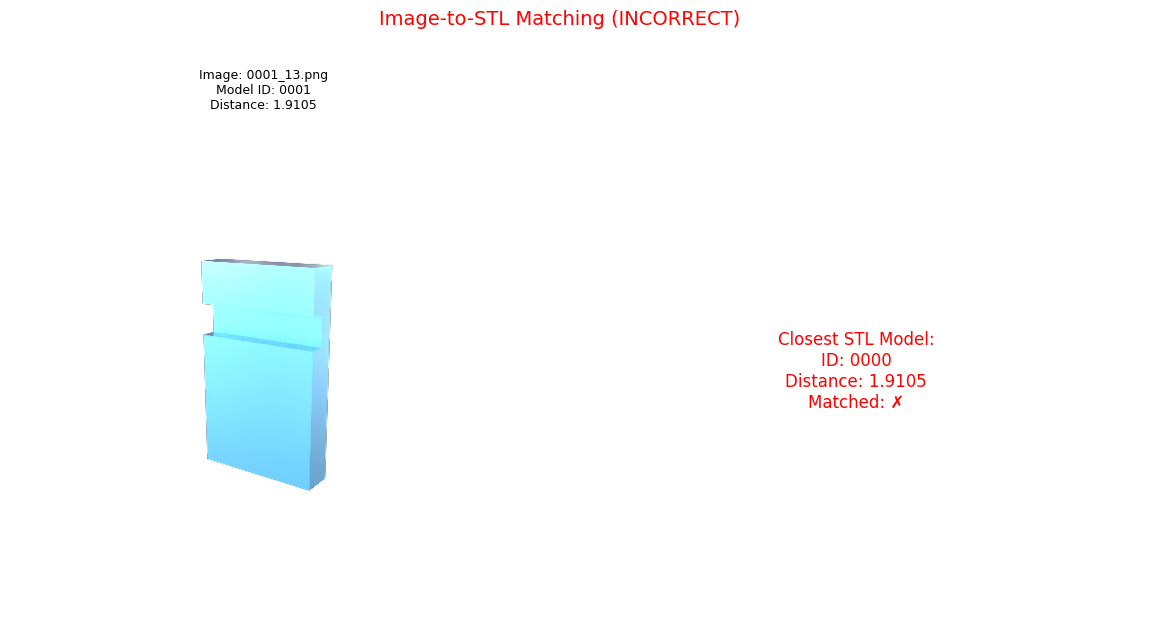

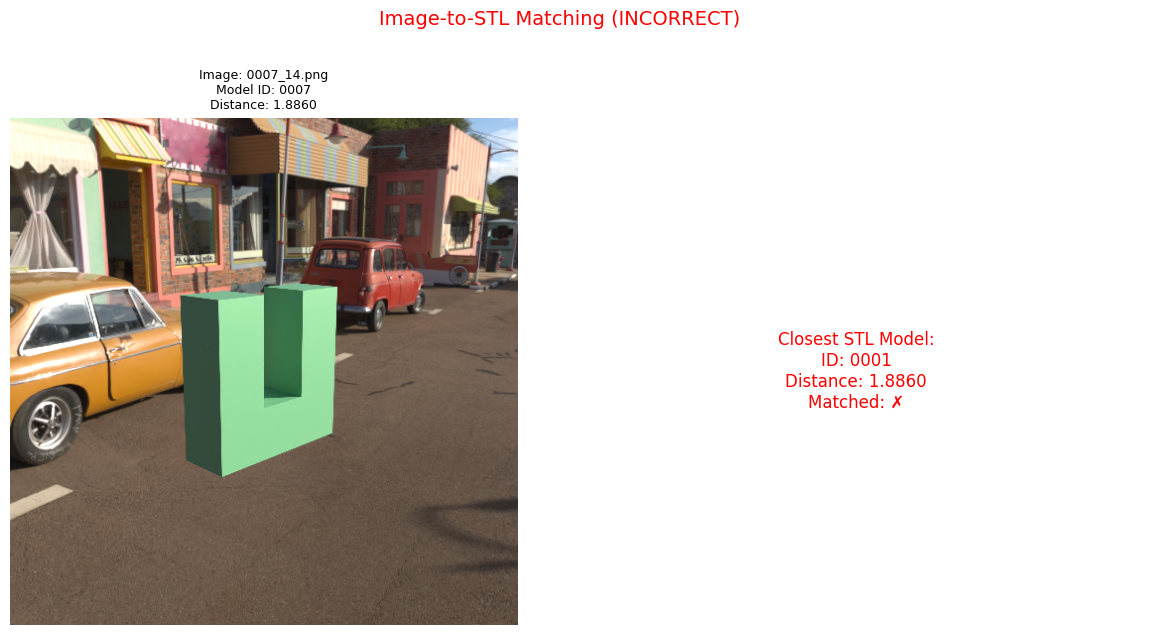

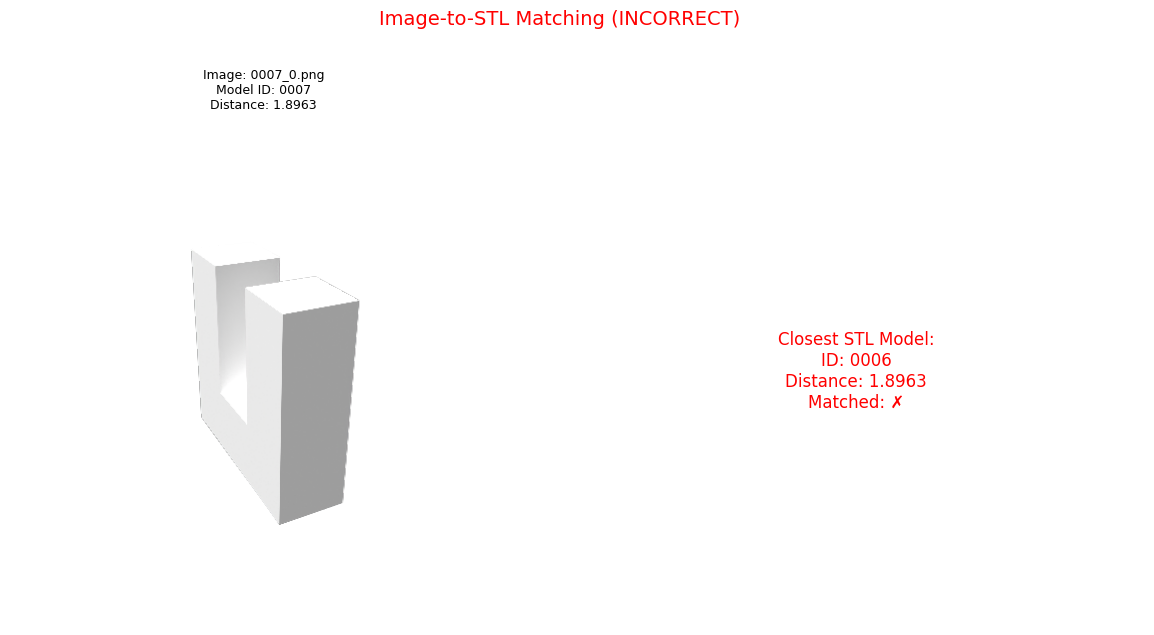

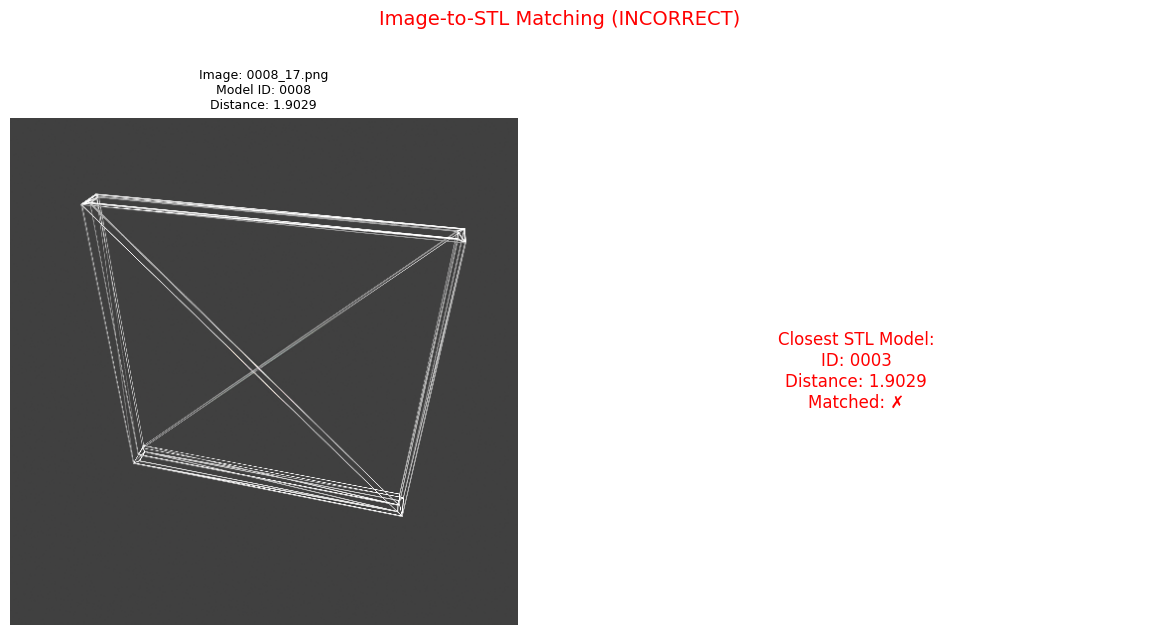

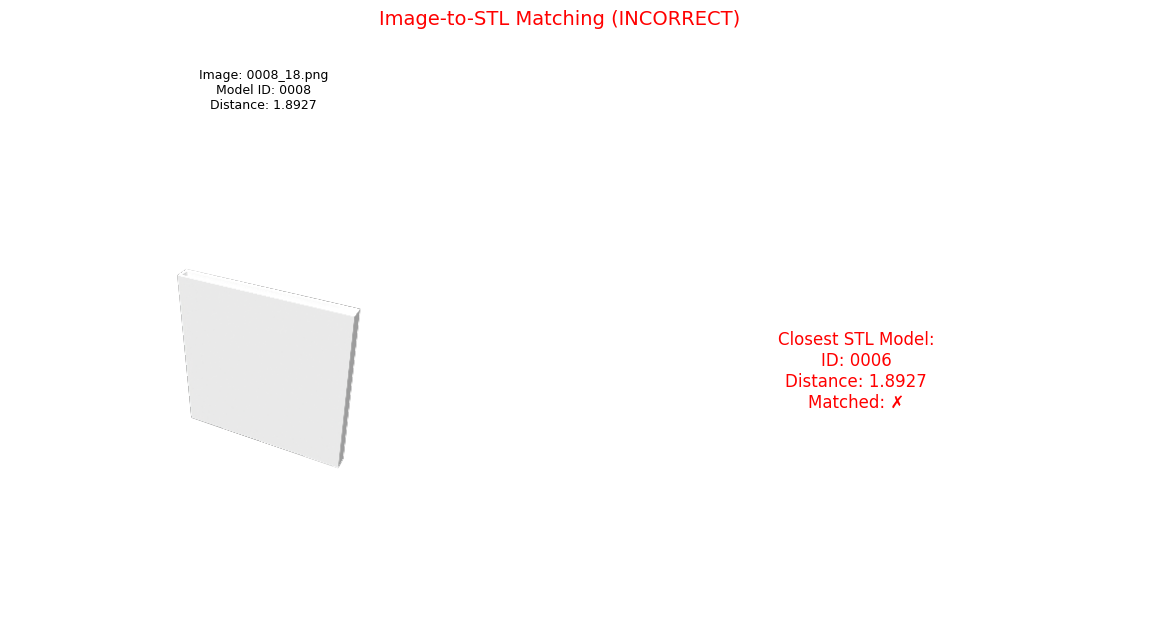

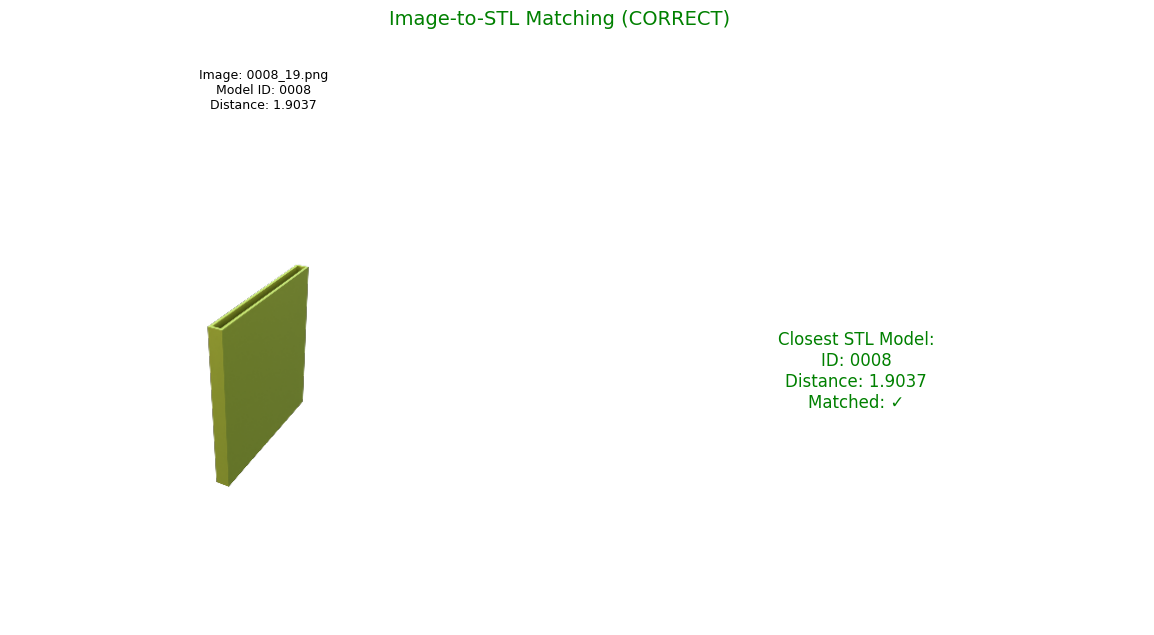

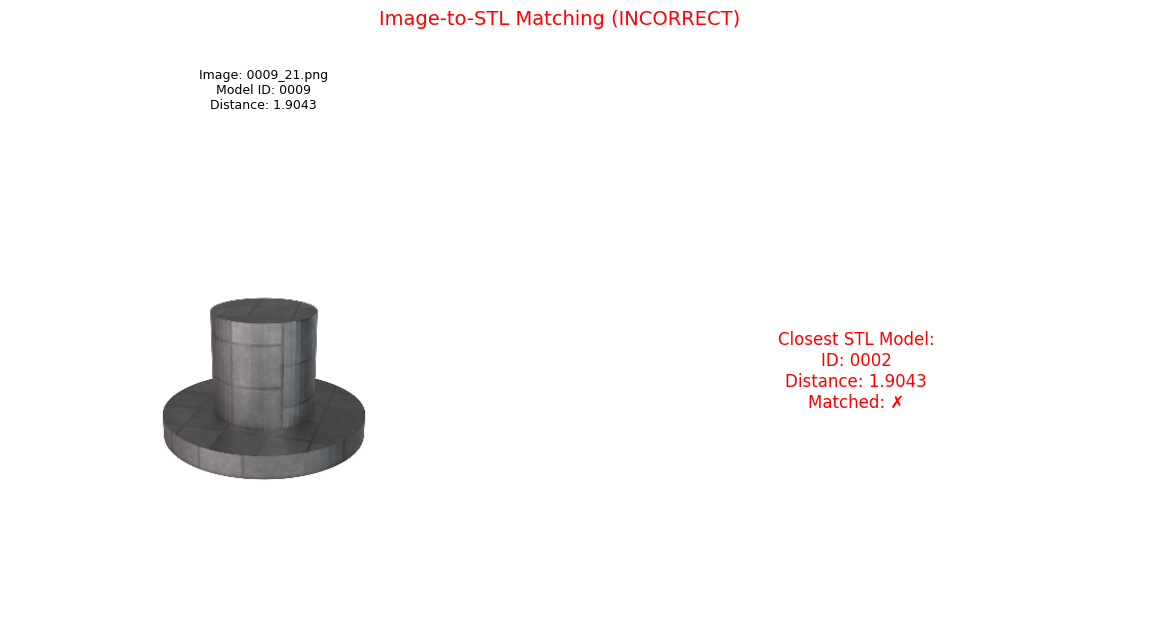

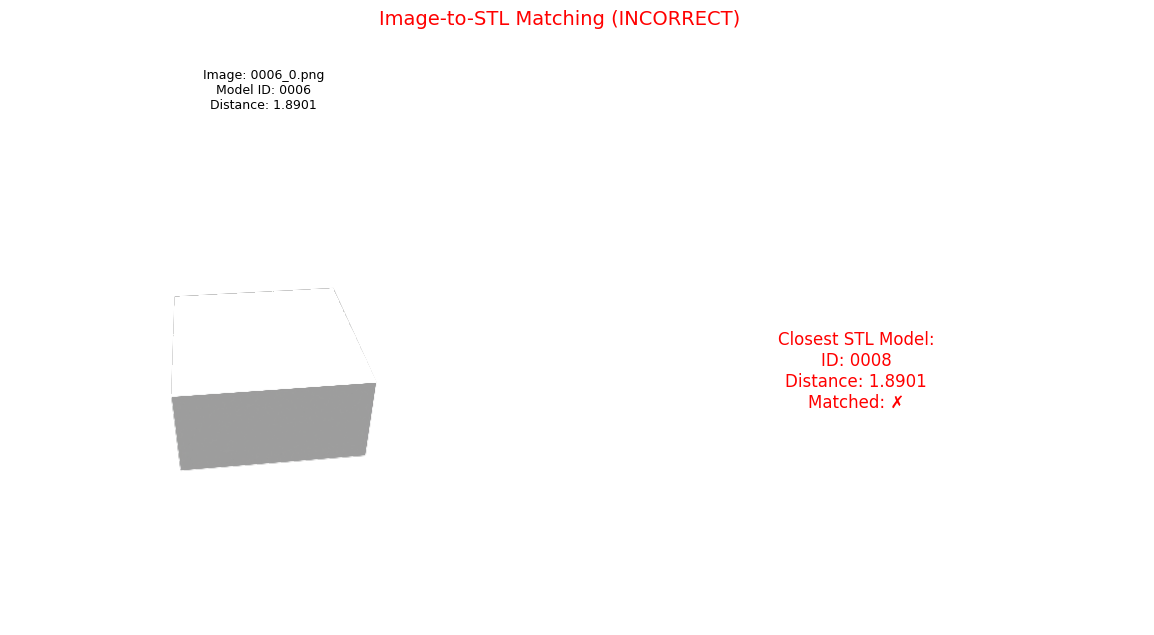

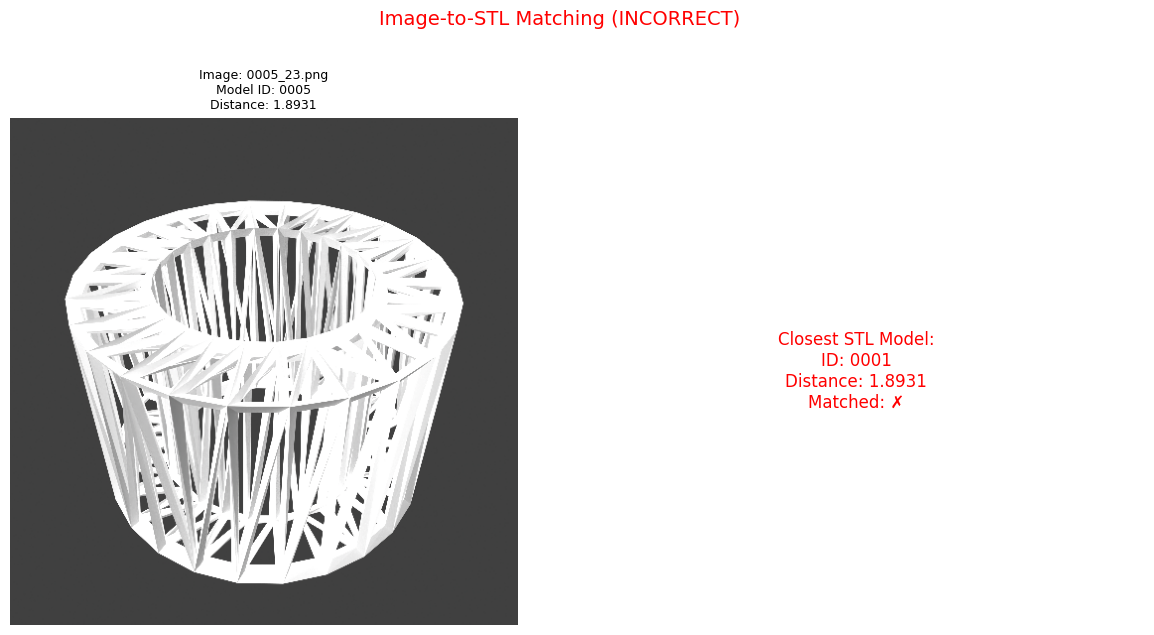

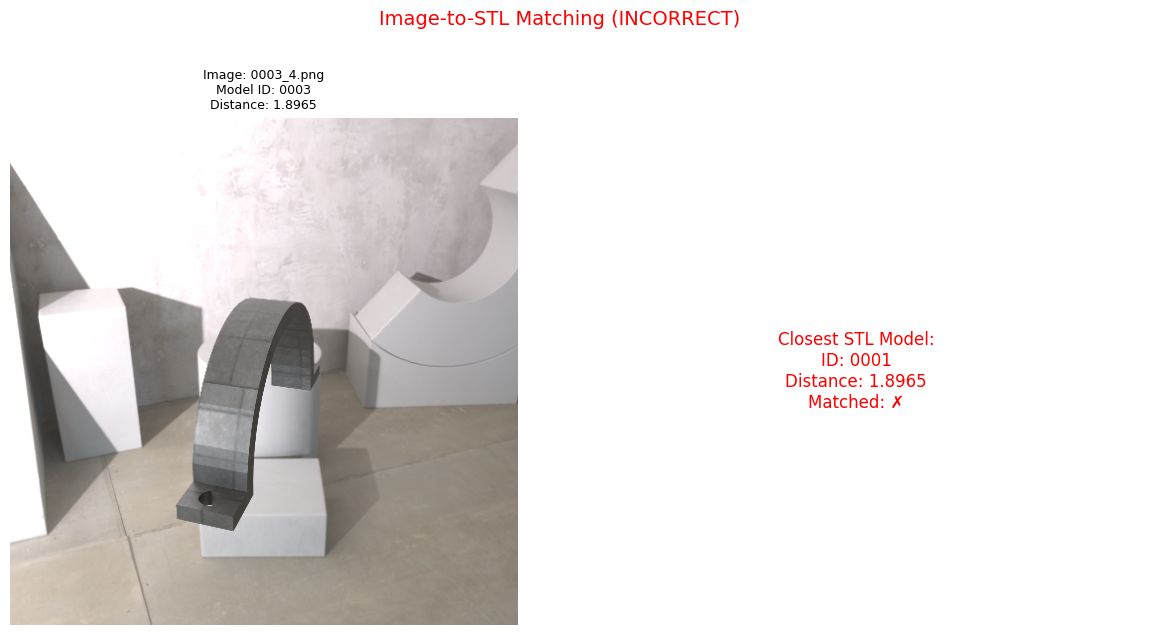

In [142]:
plot_image_to_stl_neighbors(
    image_model=image_model,
    stl_model=stl_model,
    dataloader=test_loader,
    stl_emb_dict=stl_emb_dict,
    image_folders=image_folders_2,
    n_examples=10
)